In [1]:
#Most of the work will be done in numpy, but pandas for data reading and matplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Read the csv, and tranform into numpy matrix
Data=pd.read_csv("train.csv")
Data=np.matrix(Data)

rownum=Data.shape[0]

In [2]:
#Row indices do not matter in this case, so the easiest way to random sample is to shuffle the rowes
np.random.shuffle(Data)

#Get the size of the training, test, and validation sets, so that I can split them evenly
#Percent of data in train
tr_ratio=.7
#Size of validation set
val_ratio=(1-tr_ratio)/2
#Size of test
tst_ratio=1-tr_ratio-val_ratio
tr_len=int(rownum*tr_ratio)
v_len=int(rownum*val_ratio)
tst_len=int(rownum*tst_ratio)
#See if any were left over in rounding
leftover=rownum-(tr_len+v_len +tst_len)

#Add the leftover to train. Decided to take the last tr_len rows, could take the first intead,
#as the rows where randomly reorderd
#Up to this point, the program is completely generalized, now it specificall takes data where 
#the last column is the dependent variable
X_train=Data[-(leftover+tr_len):,:-1]
y_train=Data[-(leftover+tr_len):,-1]

#Take The first v_test rows 
X_val=Data[:v_len,:-1]
y_val=Data[:v_len:,-1]

#Take the remaining
X_test=Data[v_len:v_len+tst_len,:-1]
y_test=Data[v_len:v_len+tst_len,-1]
#Make sure I am using all of the rows of data, no duplicates or missed rows
print(len(y_train)+len(y_val)+len(y_test)-rownum)

0


In [3]:
#Find index of second largest value of crit_temp, as largest is an outlier, according to above graphs. Used as center of gaussian

gs_center=np.array(y_train.reshape(1,y_train.shape[0])).argsort()[0,-2]

In [4]:
#Find the minimum and maximumm of y in order to normalize the data set 
y_tr_mean=y_train.mean()
y_std=np.std(y_train)

In [5]:
#Do a min-max normalization of ythe training data
y_train=(y_train-y_tr_mean)/y_std

In [6]:
#Apply the same normalization to the validation and test data
y_val=(y_val-y_tr_mean)/y_std
y_test=(y_test-y_tr_mean)/y_std

In [7]:
X_tr_mean=X_train.mean(0)
X_tr_std=X_train.std(0)

In [8]:
#Do the same for the X values
X_train=(X_train-X_tr_mean)/(X_tr_std)
X_val=(X_val-X_tr_mean)/(X_tr_std)
X_test=(X_test-X_tr_mean)/(X_tr_std)

In [9]:
#write phi in functional form, to make it easier to tune
def phi(X):
    phi=np.ones((X.shape[0],1))
    #Create matrix where each row is X values at the max y. Will be used for creating the desired gaussian radial functions 
    centermat=np.tile(X_train[gs_center],(X.shape[0],1))
    for i in range(6):
        #Trig functions seem to deal well with the fluctuations, 
        #while the polynomials give the fit a way to more easily deal with the fact that the data is not periodic
        phi=np.hstack((phi,np.power(X,i+1)))#,np.sin((i+1)*X), np.cos((i+1)*X)))
        #Fitting with just guassians did not work well, though adding one in does imporive the fit.
#    phi=np.hstack((phi,np.exp(-np.power((X-centermat)/2/centermat,2))))

    return phi

In [10]:
#Find phi for all three sets
phi_tr=phi(X_train)
phi_val=phi(X_val)
phi_test=phi(X_test)

In [159]:
#Initialize a starting point for w for gradient descent
w0=np.random.randn(phi_tr.shape[1],1)
wtrain=w0
#Calculate the y prediction for y for these weights
y_hat=phi_tr@w_train
#Error in first measurement. Least squares because it is faster
Error=[((y_hat-y_train).T@(y_hat-y_train))[0,0]]
eta=1e-6
lam1=.05
lam2=0.001
epochs=2000
epoch=[0]
for i in range(epochs):
    w_train=w_train-eta*(phi_tr.T@(y_hat-y_train))
    y_hat=phi_tr@w_train
    #Calculate least squares error (it takes much longer to calculate MRAE)
    Error.append(((y_hat-y_train).T@(y_hat-y_train))[0,0])
    epoch.append(i+1)

In [ ]:
plt.plot(epoch,Error)

In [ ]:
min(Error)

In [160]:
y_pred=phi_val@w_train
poly_non_reg_error=np.median(np.array(abs((y_val-y_pred)/y_val).reshape((1,y_val.shape[0]))))

In [161]:
y_pred=phi_test@w_train
poly_non_reg_error=np.median(np.array(abs((y_test-y_pred)/y_test).reshape((1,y_test.shape[0]))))

In [33]:
Error[-5:]

[3469.784457282592,
 3469.6677397760045,
 3469.5510329921945,
 3469.434336929726,
 3469.317651587164]

In [9]:
#write phi in functional form, to make it easier to tune
def phi(X):
    phi=np.ones((X.shape[0],1))
    #Create matrix where each row is X values at the max y. Will be used for creating the desired gaussian radial functions 
    centermat=np.tile(X_train[gs_center],(X.shape[0],1))
    for i in range(5):
        #Trig functions seem to deal well with the fluctuations, 
        #while the polynomials give the fit a way to more easily deal with the fact that the data is not periodic
        phi=np.hstack((phi,np.power(X,i+1),np.sin((i+1)*X), np.cos((i+1)*X)))
        #Fitting with just guassians did not work well, though adding one in does imporive the fit.
    phi=np.hstack((phi,np.exp(-np.power((X-centermat)/2/centermat,2))))

    return phi

In [11]:
#Find phi for all three sets
phi_tr=phi(X_train)
phi_val=phi(X_val)
phi_test=phi(X_test)
w0=np.linalg.inv(phi_tr.T@phi_tr+.002*np.identity(phi_tr.shape[1]))@phi_tr.T@y_train

In [17]:
#Do the same as above,but with L1 and L2 regularization (Elasticnet Regression)
w_train=w0
y_hat=phi_tr@w_train
Error=[((y_hat-y_train).T@(y_hat-y_train))[0,0]]
#eta, lam1, and lam2 were determined by finding what gave the lowest values on the validation set
eta=1e-6
lam1=.0001
lam2=0.0000001
epochs=2000
epoch=[0]
for i in range(epochs):
    w_train=w_train-eta*(phi_tr.T@(y_hat-y_train))-lam1*w_train-lam2*np.sign(w_train)
    y_hat=phi_tr@w_train
    Error.append(np.sqrt((y_hat-y_train).T@(y_hat-y_train))[0,0])
    epoch.append(i+1)

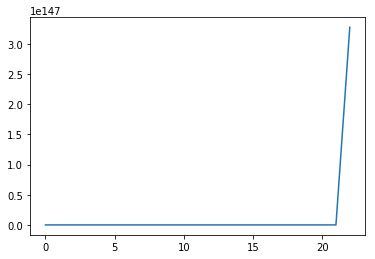

In [18]:
plt.plot(epoch,Error)

In [18]:
min(Error)

166748995.90667698

In [19]:
#Can't seem to get error very low
y_pred=phi_val@w_train
np.median(np.array(abs((y_val-y_pred)/y_val).reshape((1,y_val.shape[0]))))

nan

In [ ]:
#Can't seem to get error very low
y_pred=phi_val@w0
np.median(np.array(abs((y_val-y_pred)/y_val).reshape((1,y_val.shape[0]))))

In [25]:
y_pred=phi_test@w_train
sin_cos_gauss_poly_mrae=np.median(np.array(abs((y_test-y_pred)/y_test).reshape((1,y_test.shape[0]))))

In [175]:
poly_mrae

0.7703633001476554

In [13]:
sin_cos_gauss_poly_mrae

1.8751725191871973

In [164]:
poly_non_reg_error

0.8669177840106006